# Quantum Variational Classifier

This tutorial discusses how a quantum computer can be used to solve a classification task.<br>
The example is based on the following paper:
<br>
<br>
<b>Supervised learning with quantum enhanced feature spaces</b><br>
Vojtech Havlicek, Antonio D. Corcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow, and Jay  M. Gambetta<br>
<a href="https://arxiv.org/abs/1804.11326">arXiv:1804.11326 (2018)</a>

In [5]:
from svm.datasets import *
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer, execute
from qiskit.aqua.components.optimizers.spsa import SPSA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



## Data

Before we can train the Quantum Variational Classifier, we have to load the data set that we are interested in and split it into a training and a test set.
<br>
Note that the ad hoc data set is constructed suitably for the purpose of illustration.
<br>
<br>
<b>Exercise:</b><br>
Feel free to train and test the classifier with the alternatively given training data set:<br>
<a href="https://archive.ics.uci.edu/ml/datasets/wine">UCI Machine Learning Repository - Wine Data Set</a><br>
To switch between the data sets set the <b>use_adhoc_dataset</b> to True or False.

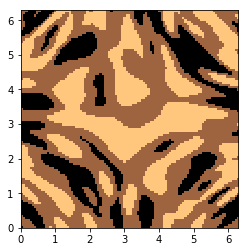

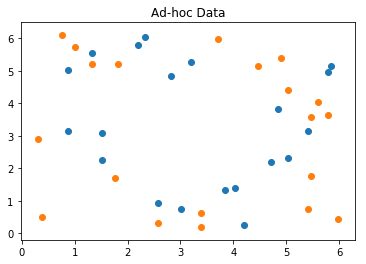

In [2]:
# size of training data set
training_size = 20

# size of test data set
test_size = 10

# dimension of data sets
n = 2

# construct training and test data
# set the following flag to True for the first data set and to False for the second dataset
use_adhoc_dataset = True
if use_adhoc_dataset:
    # first (artifical) data set to test the classifier
    training_input, test_input, class_labels = \
            ad_hoc_data(training_size=training_size, test_size=test_size, n=n, gap=0.3, plot_data=True)
else:
    # second data set to test the classifier
    training_input, test_input, class_labels = \
            Wine(training_size=training_size, test_size=test_size, n=n, plot_data=True)


## Quantum Feature Map

The Quantum Feature Map $\cal{U}_{\Phi(\vec{x})}$ is a quantum circuit parametrized by a classical input datapoint $\vec{x}$.
Thus, $\cal{U}$ maps $\vec{x}$ to the quantum feature space whose dimension is exponential in the number of qubits.
In this tutorial we use the following quantum feature map:
<img src="svm/feature_map.png">
<br>
where
### $$U_{\Phi(\vec{x})} = e^{i\left(x_1 Z \otimes I + x_2 I \otimes Z + x_1x_2Z \otimes Z \right)}$$

The classical data sample $\vec{x}$ is loaded by applying the Quantum Feature Map onto the initial quantum state $|0{\rangle}^{\otimes n}$:
### $$|\phi(\vec{x})\rangle = \cal{U}_{\Phi(\vec{x})}|0{\rangle}^{\otimes n}$$



In [3]:
def feature_map(x, q):
    
    # initialize quantum circuit
    qc = QuantumCircuit(q)
    
    # apply hadamards and U_Phi twice
    for _ in range(2):
        
        # apply the hadamard and Z-rotatiion to all qubits
        for i in range(x.shape[0]):
            qc.h(q[i])
            qc.rz(2 * x[i], q[i])
        
        # apply the two qubit gate
        qc.cx(q[0], q[1])
        qc.rz(2*(np.pi-x[0])*(np.pi-x[1]), q[1])
        qc.cx(q[0], q[1])

    # return quantum circuit
    return qc

We can now use a classical vector, for instance $\begin{pmatrix} 1.5 \\ 0.3 \end{pmatrix}$ to apply the quantum feature map onto the quantum state $|0{\rangle}^{\otimes 2}$, analyze the resulting statevector and plot the corresponding quantum circuit.

In [9]:
# initialize quantum register
num_qubits = 2
qr = QuantumRegister(num_qubits)

# initialize test data (x1, x2)
data = np.asarray([1.5, 0.3])

# get quantum circuit
qc_feature_map = feature_map(data, qr)
# simulate using local statevector simulator
backend = BasicAer.get_backend('statevector_simulator')

job_sim = execute(qc_feature_map, backend)
sim_results = job_sim.result()
print('simulation: ', sim_results)
print('statevector: ', np.round(sim_results.get_statevector(), decimals=4))

simulation:  Result(backend_name='statevector_simulator', backend_version='1.0.0', header=Obj(backend_name='statevector_simulator', backend_version='1.0.0'), job_id='d7ab1d4d-b762-4ced-a614-2c44dadc0835', qobj_id='ddba8917-f54c-49ed-81f1-b6dbdbb22551', results=[ExperimentResult(data=ExperimentResultData(statevector=[(0.04999799188765164-0.2901871929967058j), (0.023359416632460973+0.04416736057920966j), (-0.7357557507445128-0.6039081802139161j), (0.02904633440750297-0.06252896382105108j)]), header=Obj(clbit_labels=[], creg_sizes=[], memory_slots=0, n_qubits=2, name='circuit3', qreg_sizes=[['q2', 2]], qubit_labels=[['q2', 0], ['q2', 1]]), meas_level=2, name='circuit3', seed_simulator=2053036940, shots=1, status='DONE', success=True, time_taken=0.0009453296661376953)], status='COMPLETED', success=True, time_taken=0.0010061264038085938)
statevector:  [ 0.05  -0.2902j  0.0234+0.0442j -0.7358-0.6039j  0.029 -0.0625j]


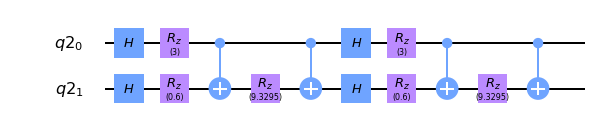

In [10]:
# draw circuit
qc_feature_map.draw(output='mpl', plot_barriers=False)

## Variational Form

The variational form is similar to an artifical neural network:
<br>
The quantum circuit receives input data, processes it through multiple layers of  parametrized quantum gates and is trained by adjusting the parameters (weights).
<br>
It should be noted that in order to optimize the parameters, the outcome of the Quantum Variational Circuit must be measured. The measurement outcome corresponds to classical bits which can be integrated in an optimization algorithm, such as gradient descent. 
<br>
<br>
In this tutorial we use the following Variational Form:
<br>
<img src="svm/variational_form.png">
<br>
The single qubit rotations denoted by $\theta_{i,j}$ correspond to Z-rotations and Y-rotations and the entangler block $U_{ent}$ consists of controlled-Z gates.
Further, the parameter $d$ denotes the depth of the Variational Circuit, i.e. the number of repitions of entangler blocks and single qubit rotation layers.
<br>
<br>
<b>Exercise:</b><br>
See how the classification performance changes when you modify the types of gates used within the quantum circuit.

In [11]:
def variational_form(q, params, depth):
    
    # initialize quantum circuit
    qc = QuantumCircuit(q)
    
    # first set of rotations
    param_idx = 0
    for qubit in range(2):
        qc.ry(params[param_idx], q[qubit])
        qc.rz(params[param_idx+1], q[qubit])
        param_idx += 2

    # entangler blocks and succeeding rotations
    for block in range(depth):
        qc.cz(q[0], q[1])
        for qubit in range(2):
            qc.ry(params[param_idx], q[qubit])
            qc.rz(params[param_idx+1], q[qubit])
            param_idx += 2
    
    # return quantum circuit
    return qc

simulation:  Result(backend_name='statevector_simulator', backend_version='1.0.0', header=Obj(backend_name='statevector_simulator', backend_version='1.0.0'), job_id='f159ee1d-f335-41fc-b624-fabadd8b730c', qobj_id='4c05ba5a-2f21-41ea-a9b9-ab2e8cf68e7a', results=[ExperimentResult(data=ExperimentResultData(statevector=[(0.6826942629255568-0.22317768515793646j), (0.3576419826068694-0.5448858090076378j), (0.15220920947977612+0.18371736894896867j), (0.0489094106875152-0.0002933895112872259j)]), header=Obj(clbit_labels=[], creg_sizes=[], memory_slots=0, n_qubits=2, name='circuit5', qreg_sizes=[['q3', 2]], qubit_labels=[['q3', 0], ['q3', 1]]), meas_level=2, name='circuit5', seed_simulator=1512373328, shots=1, status='DONE', success=True, time_taken=0.001050710678100586)], status='COMPLETED', success=True, time_taken=0.0011110305786132812)
statevector:  [0.6827-2.232e-01j 0.3576-5.449e-01j 0.1522+1.837e-01j 0.0489-3.000e-04j]


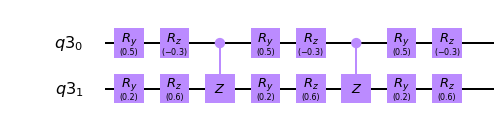

In [12]:
# initialize quantum register
num_qubits = 2
qr = QuantumRegister(num_qubits)

# set depth, i.e. number of entangler blocks and rotations (after the initial rotation)
depth = 2
params = [0.5,-0.3, 0.2, 0.6]*(depth+1)
qc_variational_form = variational_form(qr, params, depth)

# simulate using local statevector simulator
job_sim = execute(qc_variational_form, backend)
sim_results = job_sim.result()
print('simulation: ', sim_results)
print('statevector: ', np.round(sim_results.get_statevector(), decimals=4))

# draw circuit
qc_variational_form.draw(output='mpl', plot_barriers=False)

# The Quantum Variational Classifier

Before we can combine the previously introduced components to the quantum variational classifier, we need to introduce some more helper functions.

#### 1.  Assign a label to the measurement outcome 
We use the parity function to assign a class label to the measurement outcomes which are given as bit strings. In explicit, a measurement consisting of an even number of '1's is mapped to the first class, and a measurement outcome consisting of an odd number of '1's is mapped to the second class.

In [13]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [14]:
# assigns a label 
assign_label('01', class_labels)

'B'

#### 2. Map the counts of multiple shots to probabilities for the classes
After running the same circuit many times, we derive the empirical probabilities of assigning the first or second class.


In [15]:
def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0, 
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

In [16]:
return_probabilities({'00' : 10, '01': 10}, class_labels)

{'A': 0.5, 'B': 0.5}

#### 3. Combine everything to build the classifier
We combine the feature map, the variational circuit, and the label assignment to construct our (untrained) classifier.
<br>
Note that the classifier is already constructed in such a way that it is able to process a list of data points.

In [17]:
def classifier_circuit(x, params, depth):
    
    q = QuantumRegister(2)
    c = ClassicalRegister(2)    
    qc = QuantumCircuit(q, c)

    qc_feature_map = feature_map(x, q)
    qc_variational_form = variational_form(q, params, depth)

    qc += qc_feature_map
    qc += qc_variational_form

    qc.measure(q, c)
    
    return qc

def classify(x_list, params, class_labels, depth=2, shots=100):
    
    qc_list = []
    for x in x_list:
        qc = classifier_circuit(x, params, depth)
        qc_list += [qc]
    qasm_backend = BasicAer.get_backend('qasm_simulator')    
    jobs = execute(qc_list, qasm_backend, shots=shots)
    
    probs = []
    for qc in qc_list:
        counts = jobs.result().get_counts(qc)
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
            
    return probs

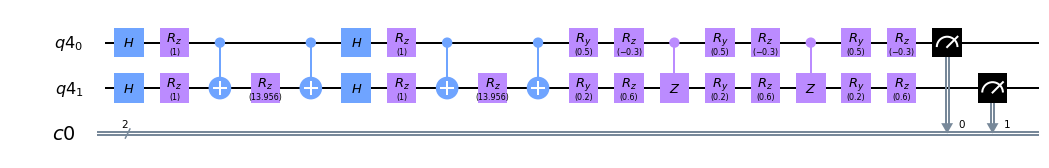

In [18]:
# draw classifier circuit
qc = classifier_circuit(np.asarray([0.5, 0.5]), params, depth)


# classify test data point (using random parameters constructed earlier)
x = np.asarray([[0.5, 0.5]])
classify(x, params, class_labels, depth)

qc.draw(output='mpl', plot_barriers=False)

#### 4. Assign a cost value to the estimation probabilities
Given a training data point and the corresponding training class label, we can calculate a cost value which represents the probability of correct/false classification. 
<br>
We only need a singificant bias towards the correct classification and, thus, use the sigmoid function to evaluate the cost value (error probability).<br>
The function is close to zero if the probability of assigning the correct class is close to one, and close to one otherwise.

In [19]:
def cost_estimate_sigmoid(probs, expected_label):

    p = probs.get(expected_label)
    sig = None
    if np.isclose(p, 0.0):
        sig = 1
    elif np.isclose(p, 1.0):
        sig = 0
    else:
        denominator = np.sqrt(2*p*(1-p))
        x = np.sqrt(200)*(0.5-p)/denominator
        sig = 1/(1+np.exp(-x))

    return sig

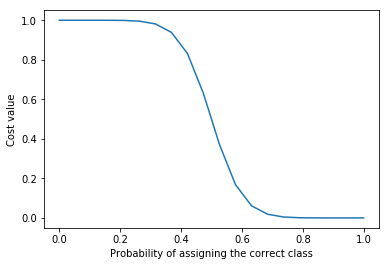

In [20]:
x = np.linspace(0, 1, 20)
y = [cost_estimate_sigmoid({'A': x_, 'B': 1-x_}, 'A') for x_ in x]
plt.plot(x, y)
plt.xlabel('Probability of assigning the correct class')
plt.ylabel('Cost value')
plt.show()

#### 5. Evaluate the overall performance for the training set
We compute the average cost value over all training data points and use this as the objective function to train our classifier.

In [21]:
def cost_function(training_input, class_labels, params, depth=2, shots=100, print_value=False):
    
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]
        
    # classify all samples
    probs = classify(training_samples, params, class_labels, depth)
    
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += cost_estimate_sigmoid(prob, training_labels[i])
    cost /= len(training_samples)
    
    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    
    # return objective value
    return cost

In [22]:
cost_function(training_input, class_labels, params, depth)

0.8902161330458769

## Train the classifier

Training the classifier corresponds to an optimization task. Explicitly, we want to minimize the cost value (sigmoid function) such that the classifier manages to properly label the given data.
<br>
<br>
<b>Exercise:</b><br>
See how the classification performance changes when you modify the depth of the variational form, the number of shots or number of trials.<br>
What's the best that you can achieve for the adhoc data set and the Wine data set?

In [26]:
# set depth of variational form
depth = 2

# set number of shots to evaluate the classification circuit
shots = 100

# set number of iterations for the optimization algorithm
# (SPSA evaluates the objective function twice per iteration)
max_trials = 25

# setup the optimizer

optimizer = SPSA(max_trials=max_trials, c0=4.0)


# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, depth, shots, print_value=True)

# randomly initialize the parameters
init_params = 2*np.pi*np.random.rand(num_qubits*(depth+1)*2)

# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)

# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.5197
0.5590
0.5659
0.5137
0.5148
0.5640
0.5199
0.5578
0.5719
0.5050
0.5441
0.5890
0.4911
0.4798
0.6991
0.6117
0.5228
0.5843
0.5078
0.3641
0.5604
0.6053
0.5158
0.5084
0.4001
0.4365
0.6589
0.6970
0.5196
0.5231
0.5017
0.5296
0.1439
0.2820
0.2012
0.1388
0.3591
0.4150
0.5947
0.6227
0.5899
0.5863
0.5986
0.6393
0.5902
0.5681
0.4824
0.4455
0.4613
0.3690
0.5229
0.4870
0.6793
0.5939
0.5095
0.5084
0.4926
0.5539
0.7876
0.8376
0.6561

opt_params: [15.97681785 -9.93765774  5.88693935 -4.00058801  2.26558529 17.35424892
 27.36679925  6.45829265  0.47802188 14.66982921  8.07514435 11.24859879]
opt_value:  0.6560543020645381


## Test the trained classifier

To check how well we could train the classifier, we evaluate the classification performance on the test data set.

----------------------------------------------------
Data point:     [6.1575216  5.02654825]
Label:          A
Assigned:       A
Probabilities:  {'A': 0.61, 'B': 0.39}
Classification: CORRECT
----------------------------------------------------
Data point:     [3.01592895 4.46106157]
Label:          A
Assigned:       A
Probabilities:  {'A': 0.66, 'B': 0.33999999999999997}
Classification: CORRECT
----------------------------------------------------
Data point:     [3.76991118 1.57079633]
Label:          A
Assigned:       B
Probabilities:  {'A': 0.29000000000000004, 'B': 0.71}
Classification: INCORRECT
----------------------------------------------------
Data point:     [2.32477856 3.01592895]
Label:          A
Assigned:       B
Probabilities:  {'A': 0.16, 'B': 0.84}
Classification: INCORRECT
----------------------------------------------------
Data point:     [4.90088454 5.71769863]
Label:          A
Assigned:       A
Probabilities:  {'A': 0.5, 'B': 0.5}
Classification: CORRECT
--------

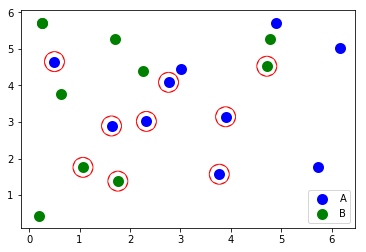

In [27]:
# collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]

# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []

# evaluate test data
for label, samples in test_input.items():
    
    # classify samples 
    results = classify(samples, opt_params, class_labels, depth, shots=shots)
    
    # analyze results
    for i, result in enumerate(results):
        
        # assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point:    ', samples[i])
        print('Label:         ', label)
        print('Assigned:      ', assigned_label)
        print('Probabilities: ', result)
        
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
        
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")

# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, facecolors='none', edgecolors='r')
plt.legend()
plt.show()